### Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import sklearn.preprocessing
import sklearn.model_selection
import sklearn.linear_model
import scipy
import csv
import sys
import random
import logging
import subprocess

In [2]:
PATH_LIBFM = "/libfm/bin/libFM" # directory where you complied the libFM binaries
PATH_CACHE = "/mnt/scratch_dir/viljanem/libfm_temp" # directory for saving temporary libFM files

In [228]:
sys.version

'3.10.9 | packaged by conda-forge | (main, Feb  2 2023, 20:20:04) [GCC 11.3.0]'

### Functions

#### LibFM estimator

In [ ]:
# download and compile: https://github.com/srendle/libfm

In [3]:
# LibSVM format required by LibFM
def save_libsvm(path, X, y):
    with open(path,'w') as file:
        writer=csv.writer(file, delimiter=' ',lineterminator='\n')
        n  = X.shape[0]
        for i in range(n):
            row = X.getrow(i)
            row_libsvm = ["%.4f" % y[i]] # label
            row_libsvm.extend(["%d:%.4f" % (i, d) for i, d, in zip(row.indices, row.data)]) # features
            writer.writerow(row_libsvm)

# LibFM learner
class LibFM(object):
    
    def __init__(self, bias = 1, dim = 16, epoch = 50, verbose=False, path_libfm=PATH_LIBFM, path_cache=PATH_CACHE):
        self.bias = bias
        self.dim = dim
        self.epoch = epoch
        self.verbose = verbose
        self.path_libfm = path_libfm
        self.path_cache = path_cache

    def fit_predict(self, X_train, y_train, X_test, y_test=None, meta=None, cache=None):

        logging.root.handlers = []
        logging.basicConfig(level=logging.INFO if self.verbose else logging.CRITICAL, 
                            format="[%(levelname)s] %(message)s",
                            handlers=[logging.StreamHandler(sys.stdout)]) 

        # Create a temporary file if no cache identifier is given
        clean = False
        if cache is None:
            cache = random.getrandbits(128)
            clean = True

        # Create data (train/test/meta)
        if not os.path.exists(self.path_cache):
            os.makedirs(self.path_cache)

        if y_test is None:
            y_test = np.zeros(X_test.shape[0])
            
        if meta is None:
            meta = np.zeros(X_train.shape[1])
            
        path_train = os.path.join(self.path_cache, "train_{0}.svm".format(cache))
        if not os.path.exists(path_train):
            logging.info("Creating {0}".format(path_train))
            save_libsvm(path_train, X_train, y_train)

        path_test = os.path.join(self.path_cache, "test_{0}.svm".format(cache))
        if not os.path.exists(path_test):
            logging.info("Creating {0}".format(path_test))
            save_libsvm(path_test, X_test, y_test)

        path_meta = os.path.join(self.path_cache, "meta_{0}.svm".format(cache))
        if not os.path.exists(path_meta):
            logging.info("Creating {0}".format(path_meta))
            np.savetxt(path_meta, meta, fmt="%d")

        # Fit model and create predictions (pred)
        path_pred = os.path.join(self.path_cache, "pred_{0}.svm".format(cache))
        command = ".{0} -task r -dim '1,{1},{2}' -method mcmc -iter {3} -train {4} -meta {5} -test {6} -out {7}"
        command = command.format(self.path_libfm, self.bias, self.dim, self.epoch, 
                                 path_train, path_meta, path_test, path_pred)   
        logging.info(command)

        with subprocess.Popen(command, shell=True, stdout=subprocess.PIPE) as execute:
            for line in execute.stdout:
                logging.info(line.decode('UTF-8').strip())

        logging.info("Reading {0}".format(path_pred))
        y_pred = np.loadtxt(path_pred)

        # Clean temporary files if necessary
        if clean:
            for path in [path_train, path_test, path_meta, path_pred]:
                if os.path.exists(path): 
                    os.remove(path)

        return(y_pred)


In [4]:
# Get out-of-sample predictions with given cross-validation and groups
def cross_validation_predict(clf, X, y, meta, cv, groups=None):
    y_cv = np.zeros(len(y))
    for i, (train, test) in enumerate(cv.split(X,y,groups=groups)):
        y_cv[test] = clf.fit_predict(X[train], y[train], X[test], y[test], meta, cache=i)
    return(y_cv)

#### Visualization

In [128]:
# Plot explained variance barplot
def plot_adjR2(meanmodel_adjR2, pairmodel_adjR2, fullmodel_adjR2, ax=None):
    # Plot
    if ax is None:
        fig, ax = plt.subplots(1,1)
    # Calculate increments in R^2
    setting1_adjR2 = pd.DataFrame({'Biases' : meanmodel_adjR2, 
                                   'Interactions' : pairmodel_adjR2-meanmodel_adjR2, 
                                   'Possible?': fullmodel_adjR2-pairmodel_adjR2,
                                   'Noise': 1-fullmodel_adjR2}, index=[''])
    setting1_adjR2.plot(ax=ax1, kind='bar', stacked=True, legend=False, color=['C0','C2', 'C1', 'C3'])
    ax.set_title('Variance explained', fontweight='bold')
    ax.set_xlabel('Model')
    ax.set_ylabel(r'Adjusted $R^2$')
    ax.set_ylim(0,1)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, loc='lower center', ncol=1)

# Plot predicted vs. observed scatter plot
def plot_calibration(y_pred, y, title='Predicted vs. Observed', vmin=None, vmax=None, ax=None):
    vmin = min(y_pred.min(), y.min()) if vmin is None else vmin
    vmax = max(y_pred.max(), y.max()) if vmax is None else vmax    
    # Plot
    if ax is None:
        fig, ax = plt.subplots(1,1)
    # Calibration plot
    ax.scatter(y_pred, y, s=1, alpha=0.1, )
    ax.set_xlim(vmin, vmax)
    ax.set_ylim(vmin, vmax)
    ax.set_aspect('equal')
    ax.set_xticks(np.arange(np.floor(vmin),np.ceil(vmax)+1))
    ax.set_yticks(np.arange(np.floor(vmin),np.ceil(vmax)+1))
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.set_xlabel('Predicted LC50')
    ax.set_ylabel('Observed LC50')
    # Add diagonal lines corresponding to RMSE
    model_rmse = np.sqrt(np.mean((y-y_pred)**2))
    ax.plot([vmin, vmax], [vmin, vmax], 'black')
    ax.plot([vmin, vmax], [vmin-model_rmse, vmax-model_rmse], 'darkorange', linestyle=(0, (5, 1)))
    ax.plot([vmin, vmax], [vmin+model_rmse, vmax+model_rmse], 'darkorange', linestyle=(0, (5, 1)))
    ax.plot([vmin, vmax], [vmin-2*model_rmse, vmax-2*model_rmse], 'darkorange', linestyle=(0, (5, 5)))
    ax.plot([vmin, vmax], [vmin+2*model_rmse, vmax+2*model_rmse], 'darkorange', linestyle=(0, (5, 5)))
    ax.plot([vmin, vmax], [vmin-3*model_rmse, vmax-3*model_rmse], 'darkorange', linestyle=(0, (5, 10)))
    ax.plot([vmin, vmax], [vmin+3*model_rmse, vmax+3*model_rmse], 'darkorange', linestyle=(0, (5, 10)))
    ax.legend(handles=[matplotlib.lines.Line2D([0], [0], color='darkorange', lw=1, linestyle=(0, (5, 1)), label=r'$\pm 1\sigma$'),
                       matplotlib.lines.Line2D([0], [0], color='darkorange', lw=1, linestyle=(0, (5, 5)), label=r'$\pm 2\sigma$'),
                       matplotlib.lines.Line2D([0], [0], color='darkorange', lw=1, linestyle=(0, (5, 10)), label=r'$\pm 3\sigma$')], 
              title='RMSE: %.2f' % np.round(model_rmse, 2), loc='lower right');


In [223]:
# Species x CAS heatmap of LC50 values
def plot_heatmap(CF, title='Species & Compound LC50 value', vmin=None, vmax=None):
    cmap = matplotlib.cm.get_cmap("jet_r").copy()
    cmap.set_bad('white',1.)
    ns, nc = CF.shape
    vmin = CF.min().min() if vmin is None else vmin
    vmax = CF.max().max() if vmax is None else vmax
    # Heatmap plot
    fig, ax = plt.subplots(1,1, figsize=(5*nc/ns, 5))
    im = ax.imshow(CF, aspect='auto', vmin=vmin, vmax=vmax, interpolation='nearest', cmap=cmap)
    ax.set_title(CF.columns.name, fontsize=12)
    ax.set_ylabel(CF.index.name, fontsize=12)
    ax.set_xlabel(title, fontsize=12)
    ax.xaxis.tick_top()
    ax.grid(False)
    ax.tick_params(axis='both', which='major', labelsize=12)
    plt.xlim(0,nc)
    plt.ylim(ns,0)
    # Add heatmap species labels
    ssd = pd.Series(np.arange(len(CF.index)), index=CF.index)
    ssd = ssd.iloc[::int((len(ssd)/20)),]
    ax.set_yticks(ssd)
    ax.set_yticklabels(ssd.index)
    # Add heatmap drug labels
    ssp = pd.Series(np.arange(len(CF.columns)), index=CF.columns)
    ssp = ssp.iloc[::int((len(ssp)/60)),]
    ax.set_xticks(ssp)
    ax.set_xticklabels(ssp.index)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    # Add colorbar
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(im, cax=cax)
    cbar.ax.yaxis.set_major_locator(plt.MultipleLocator(1))
    fig.subplots_adjust(wspace=0.02, hspace=0.02)
    
# SSD for given CAS (novel visualization)
def plot_ssd(conc1, conc2, title='Predicted SSD', vmin=None, vmax=None, annotate=True, taxonomy=None, median=False, ax=None):
    # Define color scale
    cmap = matplotlib.cm.get_cmap("jet_r").copy()
    cmap.set_bad('white',1.)
    vmin = np.min(conc1.min(), conc2.min()) if vmin is None else vmin
    vmax = np.max(conc1.max(), conc2.max()) if vmax is None else vmax
    norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
    # Calculate SSD
    p_species = conc1.sort_values().dropna()
    y_species = conc2.sort_values().dropna()
    rank_species = np.arange(1,len(p_species)+1)/len(p_species)
    ssd = pd.DataFrame({'cum_pct': rank_species, 'lc50': p_species}, index=p_species.index)
    # Plot
    if ax is None:
        fig, ax = plt.subplots(1,1)
    # Model predictions
    ssd_pred = ssd.set_index('lc50')['cum_pct']
    colors = [cmap(norm(c)) for c in ssd_pred.index]
    colors_mean = cmap(np.mean([norm(c) for c in ssd_pred.index]))
    ax.scatter(ssd_pred.index, ssd_pred, marker='.', label='predicted', c=colors)
    if median:
        i = int(len(ssd_pred)/2)
        median_lc50 = p_species[i]
        median_rank = rank_species[i] 
        ax.axvline(x=median_lc50, ymax=median_rank, linestyle = 'dashed', color='black')#
        ax.axhline(y=median_rank, xmax=(median_lc50-vmin)/(vmax-vmin), linestyle = 'dashed', color='black')
    # Observed
    ax.scatter(y_species, ssd.loc[y_species.index, 'cum_pct'], 
               marker='.', color='black', label='experiment') 
    # Observed (mean)
    y_mean = y_species.groupby(y_species.index).mean().dropna()
    colors = np.array([cmap(norm(c)) for c in y_mean])
    if taxonomy is None:
        ax.scatter(y_mean, ssd.loc[y_mean.index, 'cum_pct'], 
                   marker='o', c=colors, edgecolor='black', label='observed')
    else:
        taxes = {'fish':'s', 'crusta':'o', 'algae':'^'}
        for tax in taxes.keys():
            subset = taxonomy[y_mean.index] == tax
            ax.scatter(y_mean[subset], ssd.loc[y_mean.index, 'cum_pct'][subset], 
                    marker=taxes[tax], c=colors[subset], edgecolor='black', label='observed (%s)' % tax)
    # Annotate
    if annotate:
        labels = y_species[~y_species.index.duplicated(keep='last')]
        for (label, x,y) in zip(labels.index, labels, ssd.loc[labels.index, 'cum_pct']):
            ax.annotate(label, (x,y), xytext=(x+0.1,y), fontsize=8, ha='left', va='center')
    legend_elements = [matplotlib.lines.Line2D([0], [0], marker='.', color=colors_mean, linestyle='', label='predicted'),
                       matplotlib.lines.Line2D([0], [0], marker='.', color='black', linestyle='', label='experiment')]
    if taxonomy is None:
        legend_elements += [matplotlib.lines.Line2D([0], [0], marker='o', color='black', markerfacecolor=colors_mean, 
                                   linestyle='', label='observed')]
    else:
        legend_elements += [matplotlib.lines.Line2D([0], [0], marker=taxes[tax], color='black', markerfacecolor=colors_mean, 
                                   linestyle='', label='observed (%s)' % tax) for tax in taxes.keys()]
    # Axis styling
    ax.legend(handles=legend_elements, loc='lower right')
    ax.set_xlabel('LC50')
    ax.set_xlim(vmin, vmax)
    ax.xaxis.set_major_locator(plt.MultipleLocator(1))
    y_axis = ssd.iloc[::int((len(p_species)/20)),]
    ax.set_yticks(y_axis['cum_pct'])
    ax.set_yticklabels(y_axis.index)
    ax.set_title(title);
    ax.set_ylim(0,1)

# SSD for given CAS (traditional visualization)
def plot_ssd_traditional(conc1, conc2, title='Predicted SSD', vmin=None, vmax=None, taxonomy=None, ax=None):
    # Define color scale
    cmap = matplotlib.cm.get_cmap("jet_r").copy()
    cmap.set_bad('white',1.)
    n_species = len(conc1)
    vmin = np.min(conc1.min(), conc2.min()) if vmin is None else vmin
    vmax = np.max(conc1.max(), conc2.max()) if vmax is None else vmax
    norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
    # Plot
    if ax is None:
        fig, ax = plt.subplots(1,1)
    # Calculate SSD (predicted)
    conc1 = conc1.groupby(conc1.index).mean().dropna()
    p_species = conc1.sort_values()
    rank_species = np.arange(1,len(p_species)+1)/len(p_species)
    ssd = pd.DataFrame({'cum_pct': rank_species, 'lc50': p_species}, index=p_species.index)
    # SSD of predictions
    ssd_pred = ssd.set_index('lc50')['cum_pct']
    colors = [cmap(norm(c)) for c in ssd_pred.index]
    colors_mean = cmap(np.mean([norm(c) for c in ssd_pred.index]))
    ax.scatter(ssd_pred.index, ssd_pred, marker='.', label='predicted', c=colors)
    # Calculate SSD (observed)
    conc2 = conc2.groupby(conc2.index, sort=False).mean().dropna()
    p_species = conc2.dropna().sort_values()
    rank_species = np.arange(1,len(p_species)+1)/len(p_species)
    ssd = pd.DataFrame({'cum_pct': rank_species, 'lc50': p_species}, index=p_species.index)
    ssd_pred = ssd.set_index('lc50')['cum_pct']
    colors = np.array([cmap(norm(c)) for c in ssd_pred.index])
    # Fitted SSD to observations
    if taxonomy is None:
        ax.scatter(ssd_pred.index, ssd_pred, marker='o', label='observed', c=colors, edgecolor='black')
    else:
        taxes = {'fish':'s', 'crusta':'o', 'algae':'^'}
        for tax in taxes.keys():
            subset = taxonomy[ssd.index] == tax
            ax.scatter(ssd['lc50'][subset], ssd['cum_pct'][subset], 
                    marker=taxes[tax], c=colors[subset], edgecolor='black', label='observed (%s)' % tax)
    mu, std = scipy.stats.norm.fit(p_species)
    x = np.linspace(vmin, vmax, 1000)
    y = scipy.stats.norm.cdf(x, mu, std)
    ax.plot(x, y, color='black', label='Parametric')
    # Non-parametric SSD to observations
    ssd = pd.concat([pd.DataFrame({'cum_pct': 0.0, 'lc50': vmin}, index=['']), ssd,
                     pd.DataFrame({'cum_pct': 1.0, 'lc50': vmax}, index=[''])])
    ssd_pred = ssd.set_index('lc50')['cum_pct']
    ax.step(ssd_pred.index, ssd_pred, where='post', color='black', linestyle='dashed', label='Nonparametric')
    legend_elements = [matplotlib.lines.Line2D([0], [0], marker='.', color=colors_mean, linestyle='', label='predicted')]
    if taxonomy is None:
        legend_elements += [matplotlib.lines.Line2D([0], [0], marker='o', color='black', markerfacecolor=colors_mean, 
                                   linestyle='', label='observed')]
    else:
        legend_elements += [matplotlib.lines.Line2D([0], [0], marker=taxes[tax], color='black', markerfacecolor=colors_mean, 
                                   linestyle='', label='observed (%s)' % tax) for tax in taxes.keys()]
    # Axis styling
    ax.legend(handles=legend_elements, loc='lower right')
    ax.set_xlabel('LC50')
    ax.set_xlim(vmin, vmax)
    ax.yaxis.set_major_locator(plt.MultipleLocator(0.05))
    ax.xaxis.set_major_locator(plt.MultipleLocator(1))
    ax.set_title(title);
    ax.set_ylim(0,1)



### Data set

In [ ]:
# download: https://opendata.eawag.ch/dataset/adore

In [10]:
# Read the unfiltered ADORE data set
df = pd.read_csv('processed/ecotox_mortality_processed.csv', sep=',',
                 usecols=['tax_gs', 'test_cas', 'result_obs_duration_mean', 'result_conc1_mean_mol_log', 'tax_group'])
df.rename(columns={'tax_gs': 'species', 'test_cas':'CAS', 'result_obs_duration_mean':'duration', 'result_conc1_mean_mol_log':'conc'}, inplace=True)

In [13]:
# Species to taxonomic group mapping
taxonomy = df.groupby('species', as_index=False)['tax_group'].value_counts()
taxonomy = taxonomy[taxonomy['count'] > 0].set_index('species')['tax_group']

In [63]:
# Mapping of CAS numbers to chemical names
names_CAS = pd.read_csv('processed/before_aggregation/ecotox_properties.csv', sep=',', usecols=['test_cas', 'chem_name'])
names_CAS = names_CAS.set_index('test_cas')['chem_name']

In [11]:
# Shuffle data set, it is possible data set order reveals something about species or chemicals...
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

In [12]:
# Treat the species x CAS x duration axes as categorical
df['species'] = pd.Categorical(df['species'])
df['CAS'] = pd.Categorical(df['CAS'])
df['duration'] = pd.Categorical(df['duration'].astype(int))

In [239]:
df = df[['species', 'CAS', 'duration', 'conc']].copy()

### Summary statistics

In [14]:
print('{} experiments'.format(len(df)))

70670 experiments


In [15]:
ns = len(df['species'].unique())
nc = len(df['CAS'].unique())
nd = len(df['duration'].unique())
print('{} species, {} CAS, {} duration'.format(ns, nc, nd))

1267 species, 3295 CAS, 4 duration


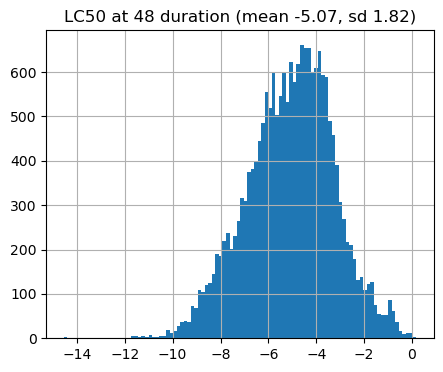

In [16]:
fig, ax = plt.subplots(1,1,figsize=(5,4))
# LC50 values at 48 duration
lc50_d48 = df.loc[df['duration'] == 48, 'conc']
mean = lc50_d48.mean()
sd = lc50_d48.std() 
# Looks roughly normally distributed
title = 'LC50 at {:d} duration (mean {:.2f}, sd {:.2f})'
ax.set_title(title.format(48,np.round(mean,2),np.round(sd,2)))
lc50_d48.hist(ax=ax, bins=100);

In [17]:
# These are the limits considered in visualization
sdmin, sdmax = mean - 3*sd, mean + 3*sd
sdmin, sdmax

(-10.520280623575538, 0.37734026566044054)

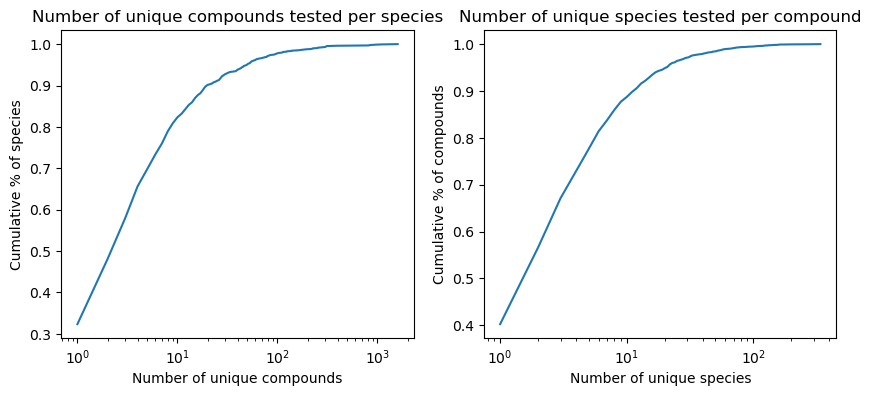

In [18]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,4))
# Number of compounds per species
nsc = df.groupby('species')['CAS'].nunique().value_counts().sort_index()
(nsc.cumsum()/nsc.sum()).plot(ax=ax1, logx=True)
ax1.set_title('Number of unique compounds tested per species')
ax1.set_xlabel('Number of unique compounds')
ax1.set_ylabel('Cumulative % of species');
# Number of species per compound
ncs = df.groupby('CAS')['species'].nunique().value_counts().sort_index()
(ncs.cumsum()/ncs.sum()).plot(ax=ax2, logx=True)
ax2.set_title('Number of unique species tested per compound')
ax2.set_xlabel('Number of unique species')
ax2.set_ylabel('Cumulative % of compounds');

### Data matrix

In [19]:
# Labels (mean centered)
y = df['conc'].values
ym = np.mean(y)
y = y - ym

# Features into one-hot-indicators
enc1 = sklearn.preprocessing.OneHotEncoder()
enc2 = sklearn.preprocessing.OneHotEncoder()
enc3 = sklearn.preprocessing.OneHotEncoder()
Xi = enc1.fit_transform(df[['species']]) # Species dummy
Xj = enc2.fit_transform(df[['CAS']]) # Drug dummy
Xd = enc3.fit_transform(df[['duration']]) # Duration dummy
Xijd = scipy.sparse.hstack([Xi, Xj, Xd], format='csr')
# Which group the feature belongs to
meta = np.concatenate([np.repeat(0, Xi.shape[1]), 
                       np.repeat(1, Xj.shape[1]), 
                       np.repeat(2, Xd.shape[1])])

# Indicator of (species, CAS)
ij = (df['species'].astype('str') + ' X ' + df['CAS'].astype('str')).astype('category').cat.codes.values
# Indicator of (species, CAS, duration) 
ijd = (df['CAS'].astype('str') + ' X ' + df['species'].astype('str') + ' X ' + df['duration'].astype('str')).astype('category').cat.codes.values

In [20]:
ym # mean of LC50

-5.153293768302886

In [21]:
# Counts of (Species, CAS) pairs
ns = Xi.shape[1]
nc = Xj.shape[1]
npairs = Xi.shape[1] * Xj.shape[1]
npairs_obs = len(np.unique(ij))
print('{} species, {} CAS, {} possible pairs {} observed pairs'.format(ns, nc, npairs, npairs_obs))

1267 species, 3295 CAS, 4174765 possible pairs 18966 observed pairs


### Explained variance

In [22]:
# 10-Fold cross validation grouped by species x compound
cv = sklearn.model_selection.GroupKFold(n_splits=10)

#### Fit 4 models

In [23]:
# Fit a model: global mean
clf = LibFM(bias = 0, dim = 0, epoch = 2000)
y_cv = cross_validation_predict(clf, Xijd, y, meta, cv, ij)
# Metrics
nullmodel_resvar = np.mean((y-y_cv)**2)
nullmodel_adjR2 = (nullmodel_resvar-nullmodel_resvar)/nullmodel_resvar
nullmodel_rmse = np.sqrt(nullmodel_resvar)

In [24]:
# Fit a model: species and compound means
clf = LibFM(bias = 1, dim = 0, epoch = 2000)
y_cv = cross_validation_predict(clf, Xijd, y, meta, cv, ij)
# Metrics
meanmodel_resvar = np.mean((y-y_cv)**2) 
meanmodel_adjR2 = (nullmodel_resvar-meanmodel_resvar)/nullmodel_resvar
meanmodel_rmse = np.sqrt(meanmodel_resvar)

In [26]:
# Fit a model: means and pairwise interactions
clf = LibFM(bias = 1, dim = 32, epoch = 2000)
y_cv = cross_validation_predict(clf, Xijd, y, meta, cv, ij)
# Metrics
pairmodel_resvar = np.mean((y-y_cv)**2) 
pairmodel_adjR2 = (nullmodel_resvar-pairmodel_resvar)/nullmodel_resvar
pairmodel_rmse = np.sqrt(pairmodel_resvar)

In [37]:
# Best possible model predicts the mean in the test set
enc = sklearn.preprocessing.OneHotEncoder()
X_k = enc.fit_transform(ijd.reshape(-1,1))
clf = sklearn.linear_model.LinearRegression(fit_intercept=False)
clf.fit(X_k, y)
y_k = clf.predict(X_k)
df_k = X_k.shape[0] - X_k.shape[1]
# Metrics
fullmodel_resvar = np.sum((y-y_k)**2) / df_k # residual sum of squares divided by degrees of freedom
fullmodel_adjR2 = (nullmodel_resvar-fullmodel_resvar)/nullmodel_resvar
fullmodel_rmse = np.sqrt(fullmodel_resvar)

In [28]:
del X_k
del y_k

In [31]:
print('RMSE: {} null, {} means, {} pairwise, {} perfect'.format(np.round(nullmodel_rmse, 3), np.round(meanmodel_rmse, 3), np.round(pairmodel_rmse,3), np.round(fullmodel_rmse,3)))
print('AdjR2: {} null, {} means, {} pairwise, {} perfect'.format(np.round(nullmodel_adjR2, 3), np.round(meanmodel_adjR2, 3), np.round(pairmodel_adjR2,3), np.round(fullmodel_adjR2,3)))

RMSE: 1.77 null, 0.962 means, 0.847 pairwise, 0.509 perfect
AdjR2: 0.0 null, 0.704 means, 0.771 pairwise, 0.917 perfect


### Validation Plot

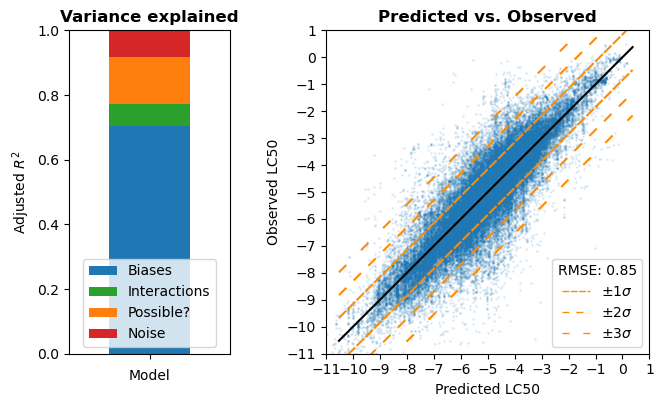

In [129]:
# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [0.8, 2]}, figsize=(8,4.2))
plot_adjR2(meanmodel_adjR2, pairmodel_adjR2, fullmodel_adjR2, ax=ax1)
plot_calibration(y_cv+ym, y+ym, vmin=sdmin, vmax=sdmax, ax=ax2)
# Save
plt.savefig('validation.tif', dpi=300, bbox_inches='tight')
plt.savefig('validation.pdf', dpi=300, bbox_inches='tight')

In [33]:
# Diagonal bands indicate standard deviation of normal distribution
sd1 = np.round(2*scipy.stats.norm.sf(1)*100, 1) # % outside 1sd
sd2 = np.round(2*scipy.stats.norm.sf(2)*100, 1) # % outside 2sd
sd3 = np.round(2*scipy.stats.norm.sf(3)*100, 1) # % outside 3sd
print('{}% 1sd, {}% 2sd, {}% 3sd'.format(sd1, sd2, sd3))

31.7% 1sd, 4.6% 2sd, 0.3% 3sd


In [240]:
# Out-of-sample predictions for training data
df['predicted'] = ym + y_cv

In [241]:
df.head()

species         CAS duration      conc  predicted
0   Pimephales_promelas    552-89-6       48 -3.859179  -4.134214
1  Eudiaptomus_gracilis   2702-72-9       96 -3.509406  -3.158274
2     Menidia_beryllina    123-86-4       96 -2.797885  -3.489874
3   Ictalurus_punctatus     94-09-7       24 -3.739423  -3.751064
4   Carassius_carassius  13171-21-6       96 -2.698521  -4.284266

### Complete the cheese

In [233]:
# Dataset of all possible experiments
species = df[['species']].drop_duplicates()
drugs = df[['CAS']].drop_duplicates()
duration = df[['duration']].drop_duplicates()
tb = species.merge(drugs, how='cross').merge(duration, how='cross')

In [234]:
# Fit a model to training set experiments and predict all possible experiments
path_pred = os.path.join(PATH_CACHE, "pred_experiments.svm")
if os.path.exists(path_pred):
    y_all = np.loadtxt(path_pred)
else:
    # Features in LibFM
    Xijd_ = scipy.sparse.hstack([enc1.transform(tb[['species']]),
                                 enc2.transform(tb[['CAS']]),
                                 enc3.transform(tb[['duration']])], format='csr')
    # Fit LibFM
    clf = LibFM(bias = 1, dim = 32, epoch = 2000, verbose=True)
    y_all = clf.fit_predict(Xijd, y, Xijd_, meta=meta, cache='experiments')
    del Xijd_
# Add predictions to dataset
tb['predicted'] = y_all + ym

In [235]:
tb.head()

species        CAS duration  predicted
0  Pimephales_promelas   552-89-6       48  -3.871404
1  Pimephales_promelas   552-89-6       96  -3.972544
2  Pimephales_promelas   552-89-6       24  -3.785844
3  Pimephales_promelas   552-89-6       72  -3.961734
4  Pimephales_promelas  2702-72-9       48  -2.997874

### Save predictions

In [247]:
# Order by highest predicted species sensitivity (at 48 hours) 
species_mean = tb[tb['duration'] == 48].groupby('species')['predicted'].mean()
species_order = species_mean.sort_values(ascending=True).index

# Order by highest predicted chemical toxicity (at 48 hours)
drug_mean = tb[tb['duration'] == 48].groupby('CAS')['predicted'].mean()
drug_order = drug_mean.sort_values(ascending=True).index 

# Order by highest predicted duration toxicity 
duration_mean = tb.groupby('duration')['predicted'].mean()
duration_order = duration_mean.sort_values(ascending=True).index 

In [248]:
# Number of tests on a species, drug, and duration
species_n = df.groupby('species')['CAS'].nunique()#.value_counts().sort_index()
drug_n = df.groupby('CAS')['species'].nunique()#.value_counts().sort_index()
duration_n = df.groupby('duration').apply(lambda df: len(df[['species', 'CAS']].drop_duplicates()))

In [246]:
# Counts of experiments for species, chemicals and duration
pd.concat([pd.DataFrame({'type':'species', 'label': species_order,'n': species_order.map(species_n)}),
           pd.DataFrame({'type':'chemical', 'label': drug_order, 'n': drug_order.map(drug_n)}),
           pd.DataFrame({'type':'duration', 'label': duration_order, 'n': duration_order.map(duration_n)})], axis=0).to_csv('counts.csv', index=False)

# Data set (out-of-sample) and complete data predictions
df.to_csv('data.csv', index=False)
tb.to_csv('predictions.csv', index=False)

### Heatmap

In [122]:
cmap = matplotlib.cm.get_cmap("jet_r").copy()
cmap.set_bad('white',1.)

#### Observed

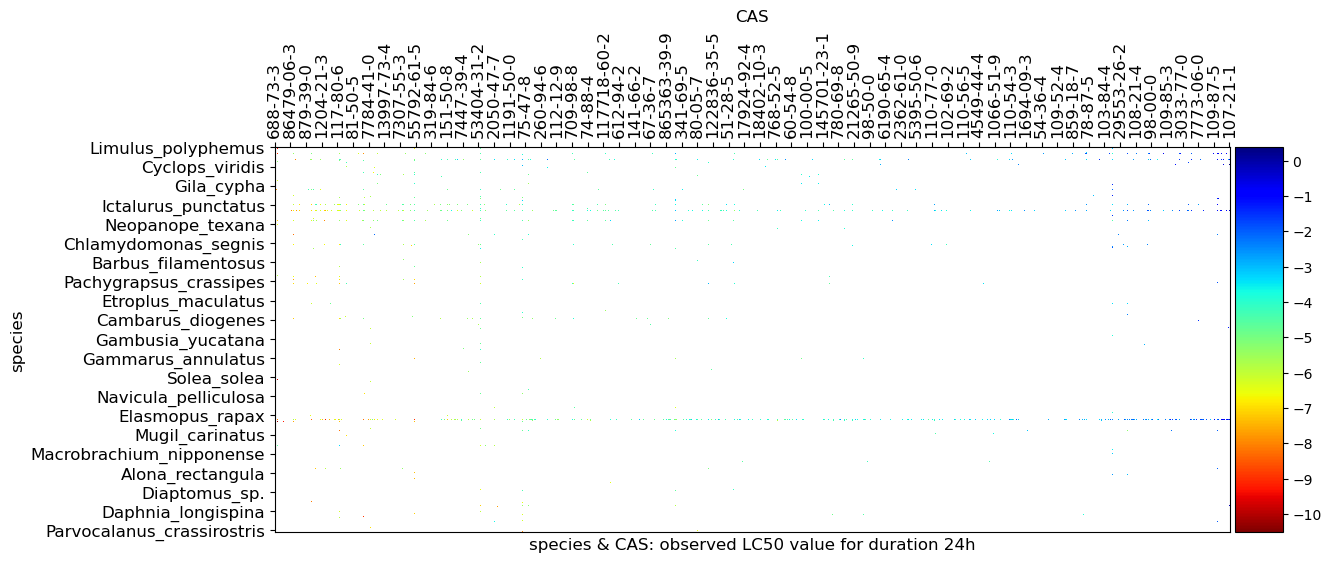

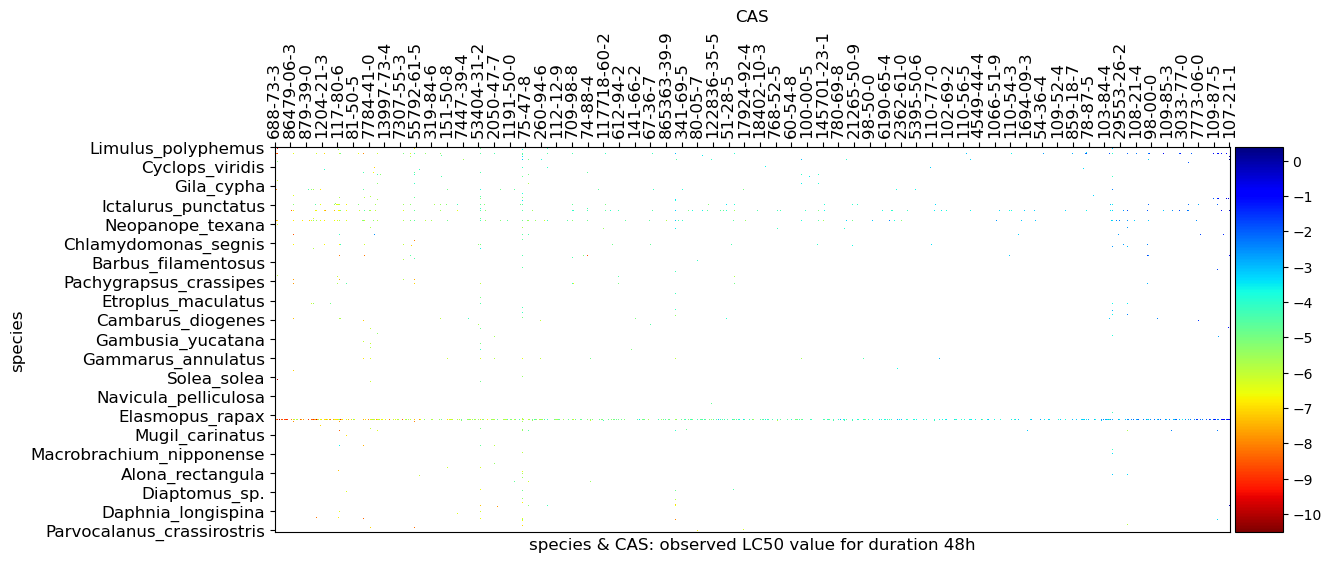

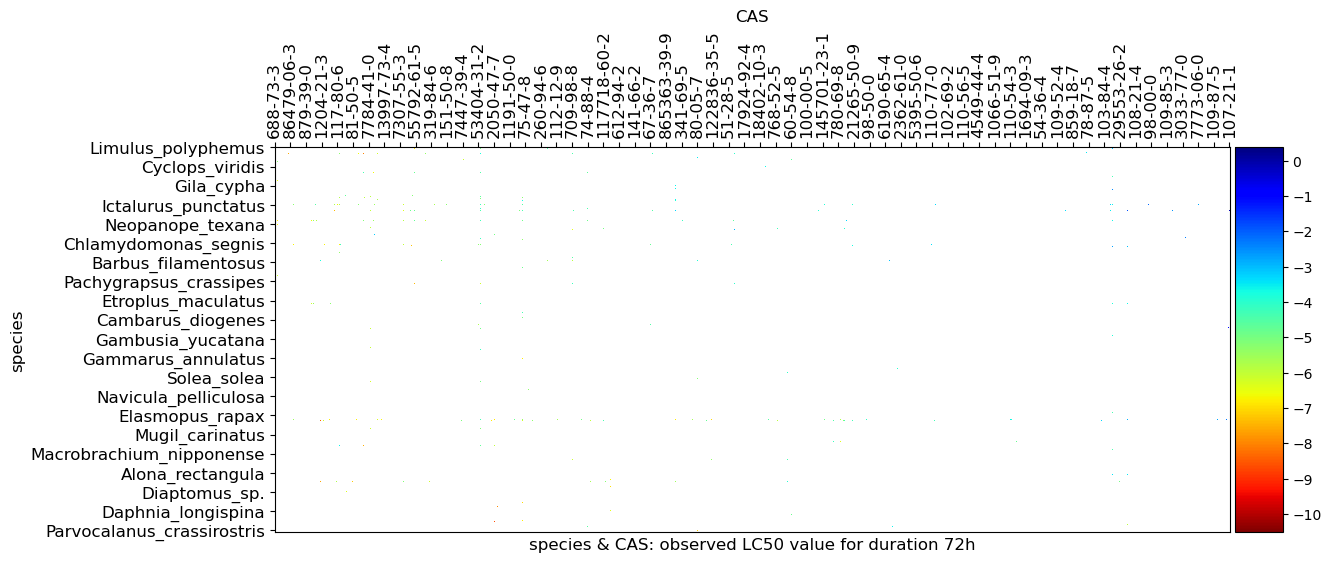

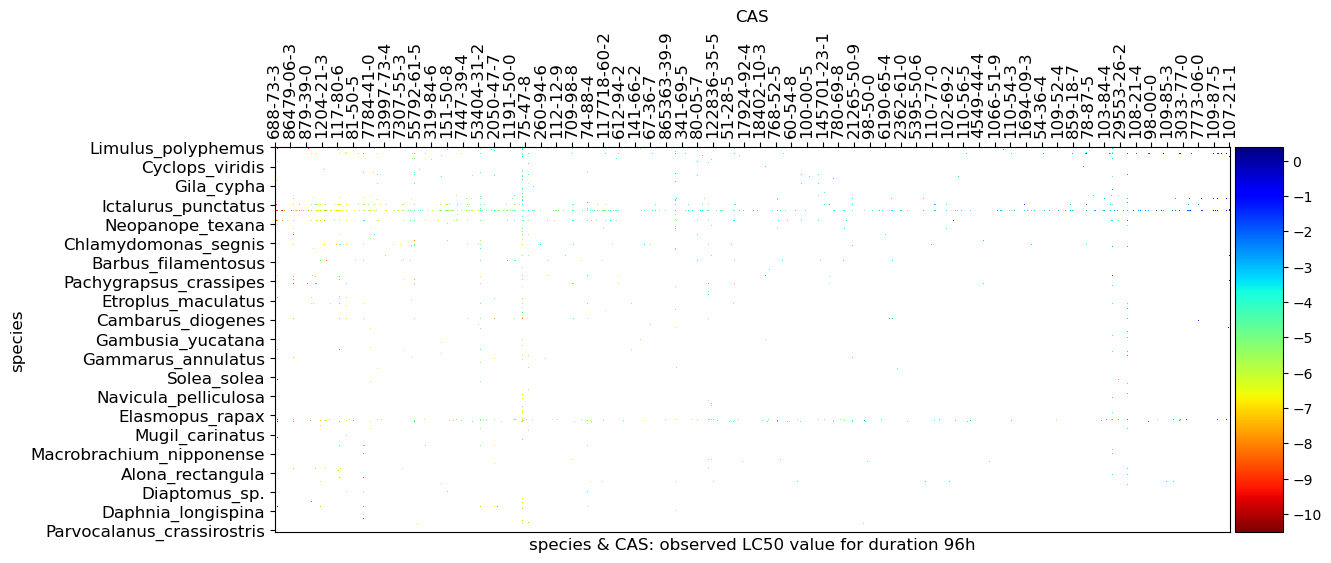

In [123]:
# Heatmap, observed values for all durations
for d in [24,48,72,96]:
    title = 'species & CAS: observed LC50 value for duration %dh' % d
    CF = pd.pivot_table(df[df['duration'] == d], index='species', columns='CAS', values='conc')
    CF = CF.reindex(index=species_order[::-1], columns=drug_order)
    plot_heatmap(CF, title, sdmin, sdmax)  
    plt.savefig('heatmap_%d.tif'%d, dpi=300, bbox_inches='tight')
    # Save pixel by pixel figure without axis labels
    matplotlib.image.imsave('heatmap_noaxis_observed_%d.png'%d, CF, vmin=sdmin, vmax=sdmax, cmap=cmap)

#### Predicted

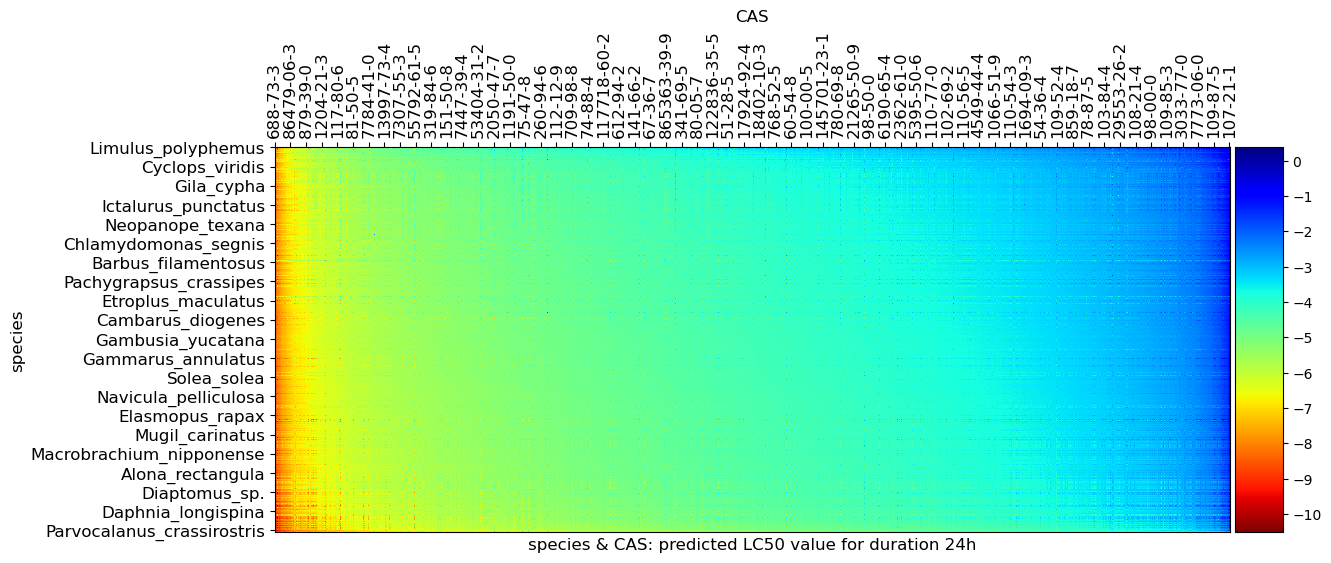

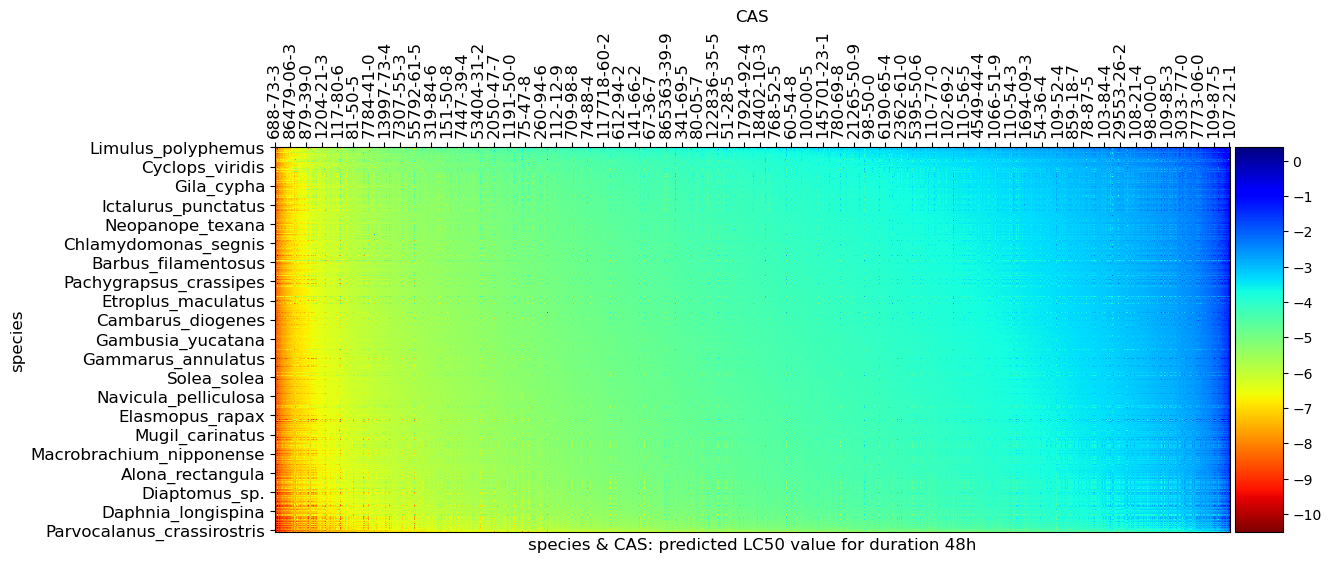

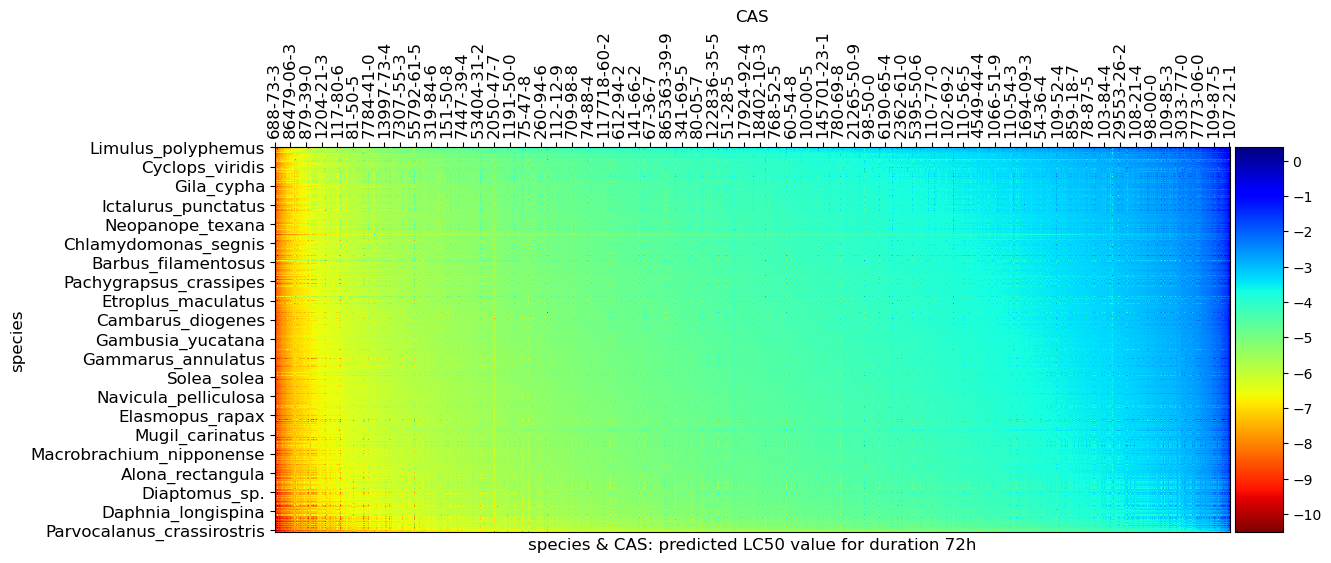

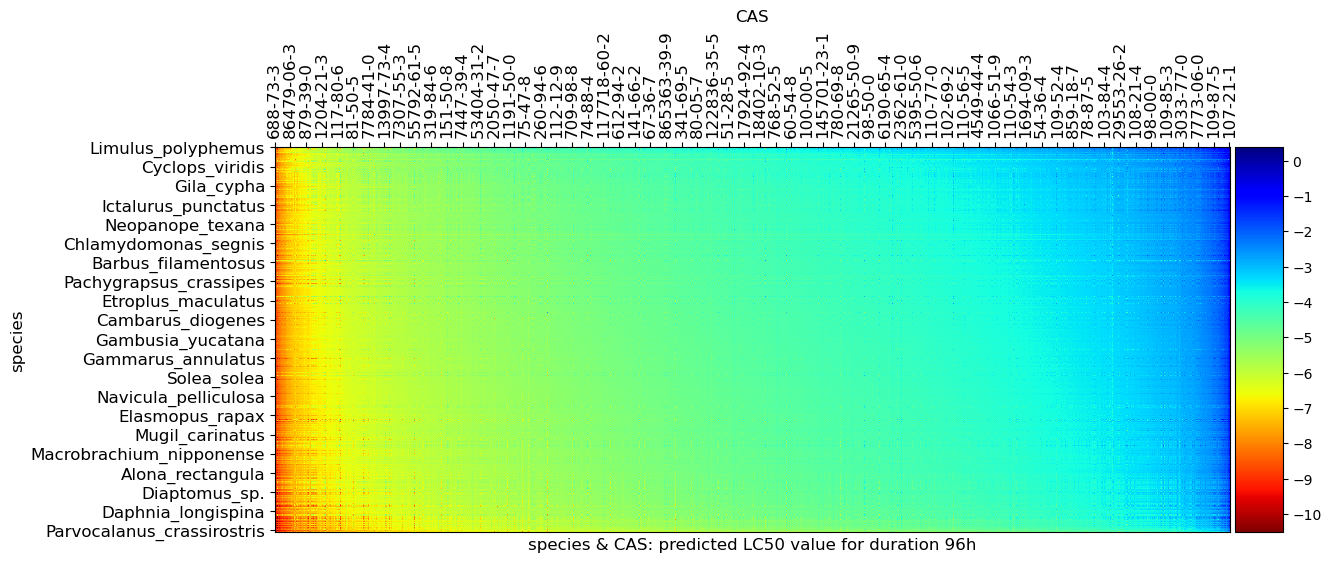

In [130]:
# Heatmap, predicted values for all durations
for d in [24,48,72,96]:
    title = 'species & CAS: predicted LC50 value for duration %dh' % d
    CF = pd.pivot_table(tb[tb['duration'] == d], index='species', columns='CAS', values='predicted')
    CF = CF.reindex(index=species_order[::-1], columns=drug_order)
    plot_heatmap(CF, title, sdmin, sdmax)
    plt.savefig('heatmap_predicted_%d.tif'%d, dpi=300, bbox_inches='tight')
    # Save pixel by pixel figure without axis labels
    matplotlib.image.imsave('heatmap_noaxis_predicted_%d.png'%d, CF, vmin=sdmin, vmax=sdmax, cmap=cmap)


#### Predicted (column sorted)

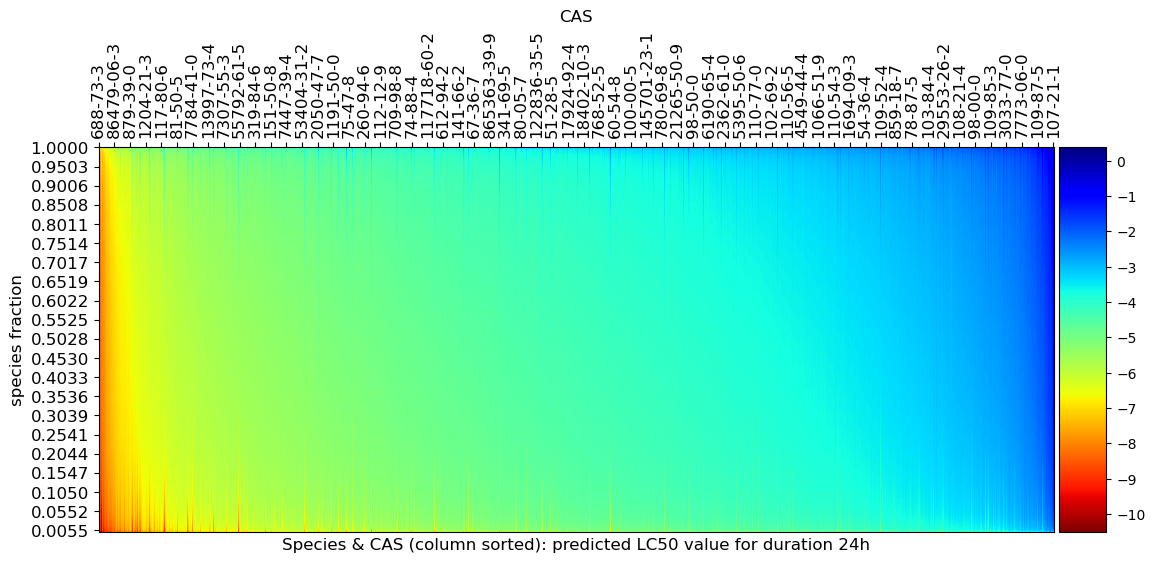

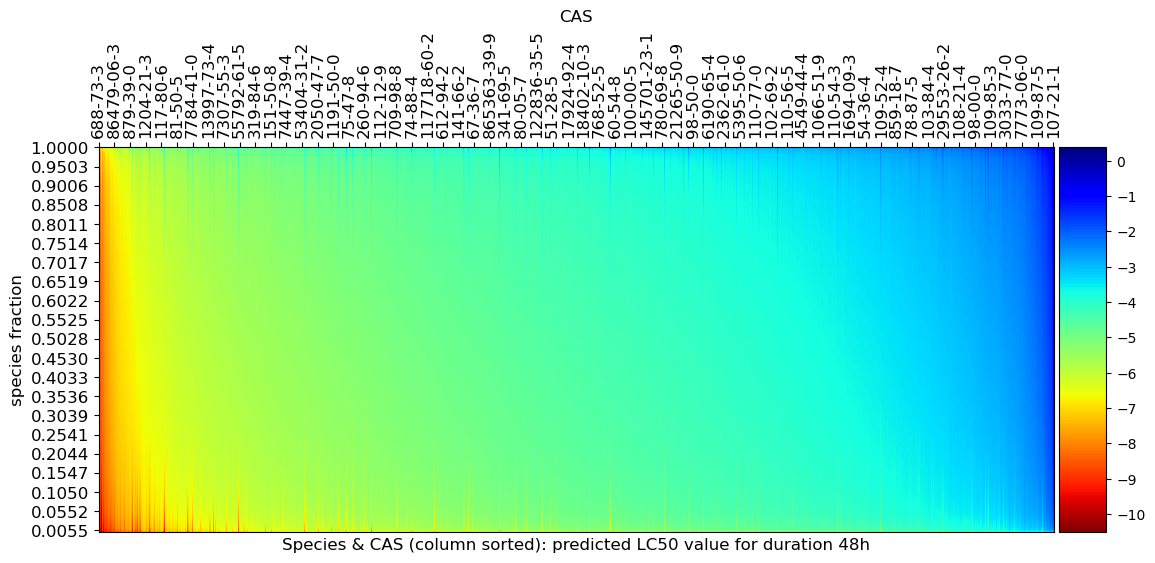

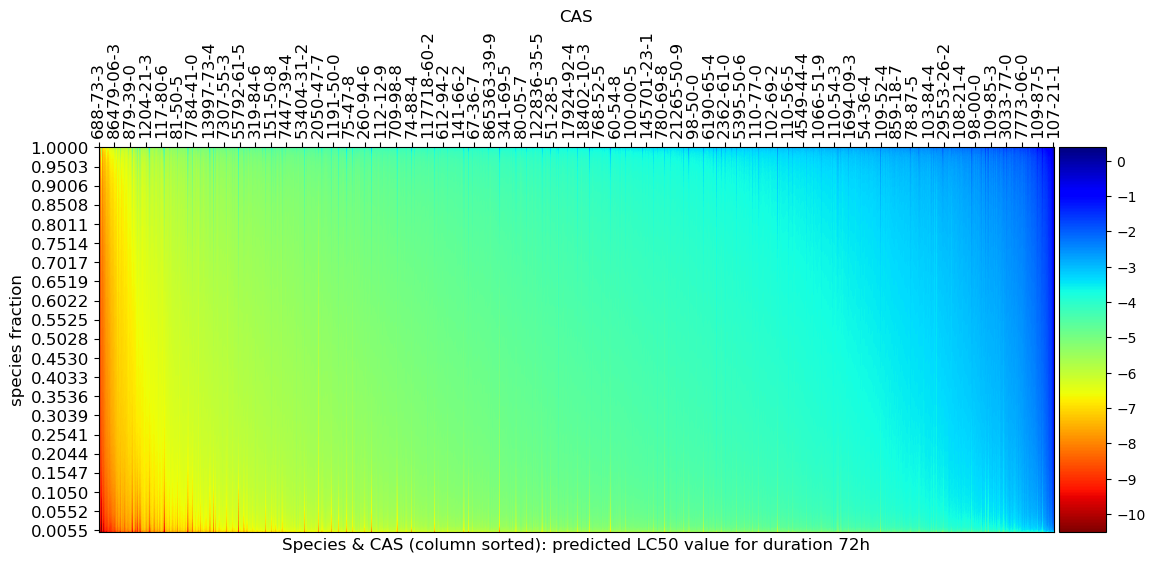

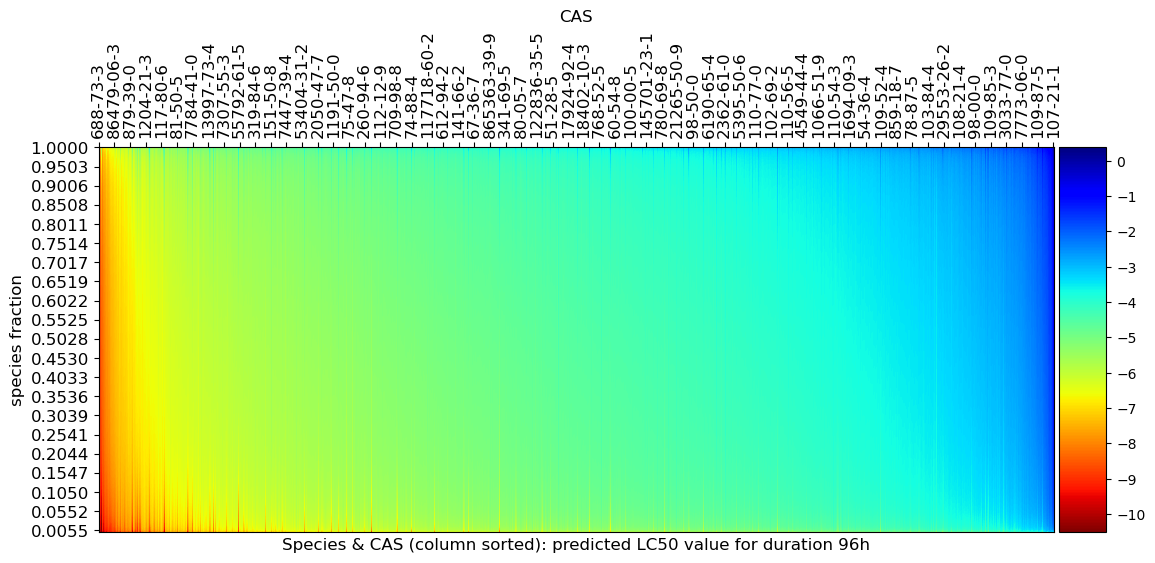

In [133]:
# Heatmap, predicted values (column sorted) for all durations
for d in [24,48,72,96]:
    title = 'Species & CAS (column sorted): predicted LC50 value for duration %dh' % d
    CF = pd.pivot_table(tb[tb['duration'] == d], index='species', columns='CAS', values='predicted')
    CF = CF.reindex(index=species_order, columns=drug_order)
    # Sort columns
    CF[:] = -np.sort(-CF, axis=0)
    fraction = np.arange(len(species_order),0,-1)/len(species_order)
    CF.index = pd.Index(['%.4f' % x for x in np.round(fraction, 4)], name='species fraction')
    plot_heatmap(CF, title, sdmin, sdmax)
    plt.savefig('heatmap_predicted_col_sorted_%d.tif'%d, dpi=300, bbox_inches='tight')

#### Predicted (row sorted)

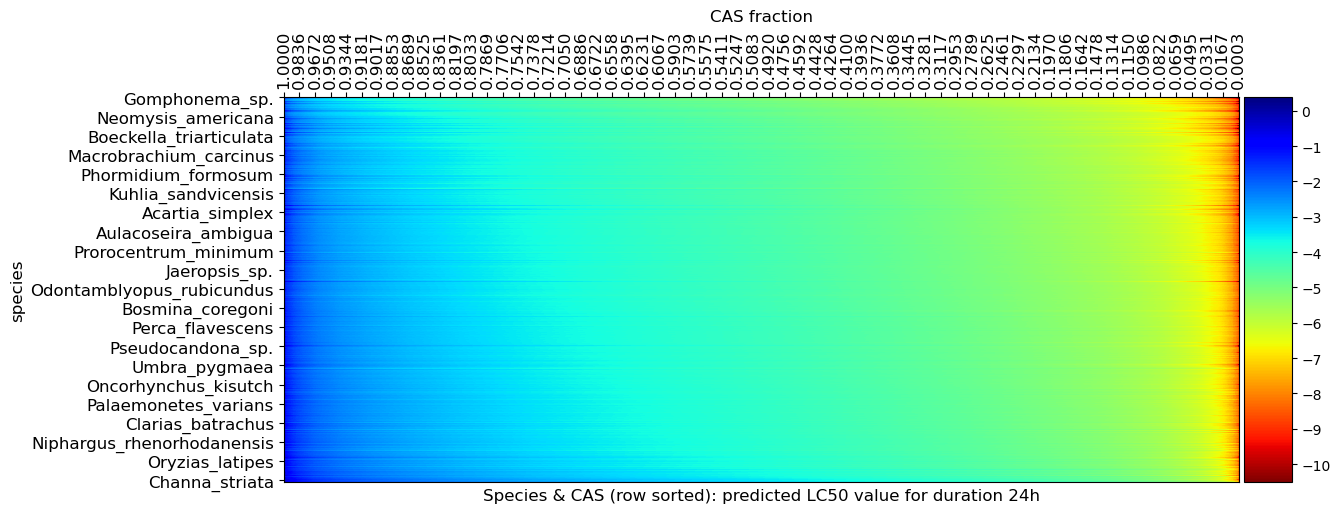

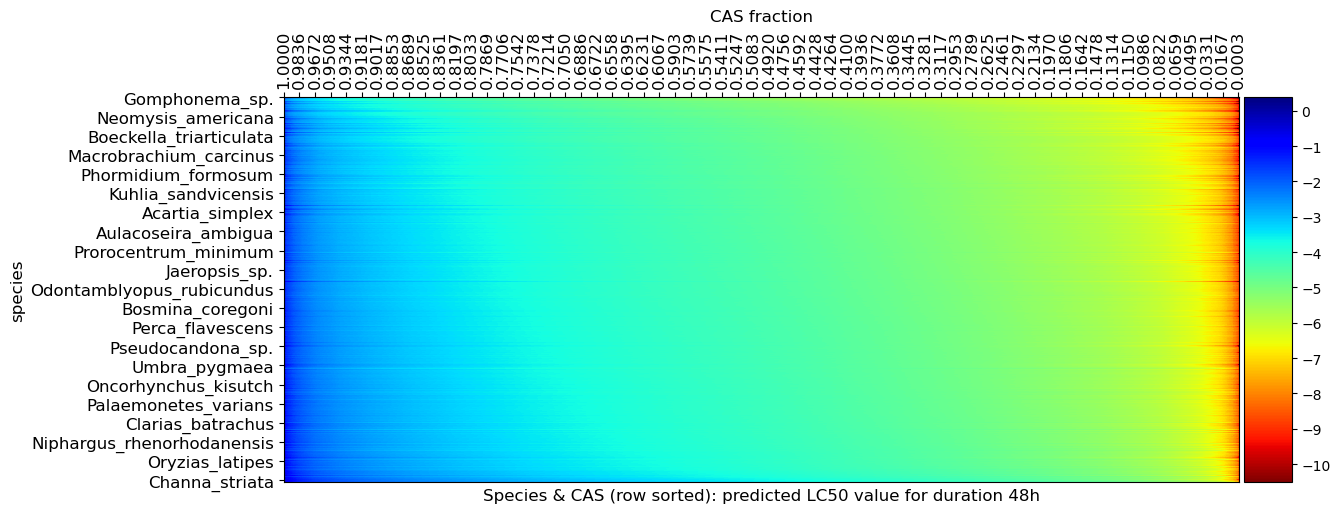

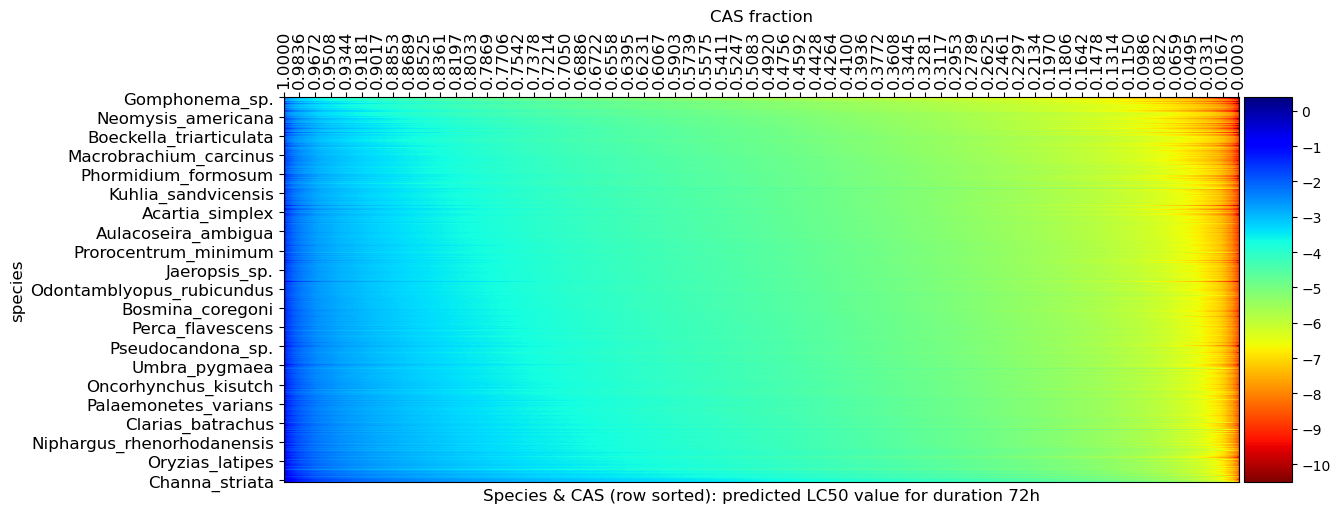

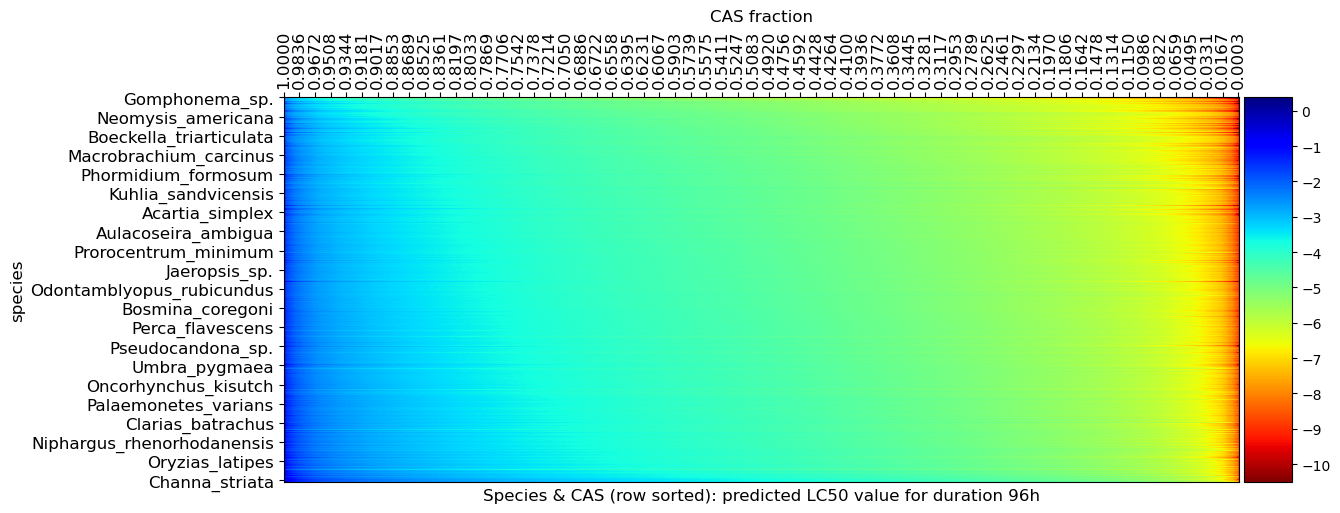

In [134]:
# Heatmap, predicted values (row sorted) for all durations
for d in [24,48,72,96]:
    title = 'Species & CAS (row sorted): predicted LC50 value for duration %dh' % d
    CF = pd.pivot_table(tb[tb['duration'] == d], index='species', columns='CAS', values='predicted')
    CF = CF.reindex(index=species_order, columns=drug_order)
    # Sort rows
    CF[:] = -np.sort(-CF, axis=1)
    fraction = np.arange(len(drug_order),0,-1)/len(drug_order)
    CF.columns = pd.Index(['%.4f' % x for x in np.round(fraction, 4)], name='CAS fraction')
    plot_heatmap(CF, title, sdmin, sdmax)
    plt.savefig('heatmap_predicted_row_sorted_%d.tif'%d, dpi=300, bbox_inches='tight')

In [135]:
del CF

### SSD

In [224]:
# Some example chemicals
drugs = ['84-74-2', '15972-60-8', '85-34-7', '85-01-8', '68359-37-5']
#drugs = np.random.choice(drug_n[drug_n >= 5].index, 5, replace=False)

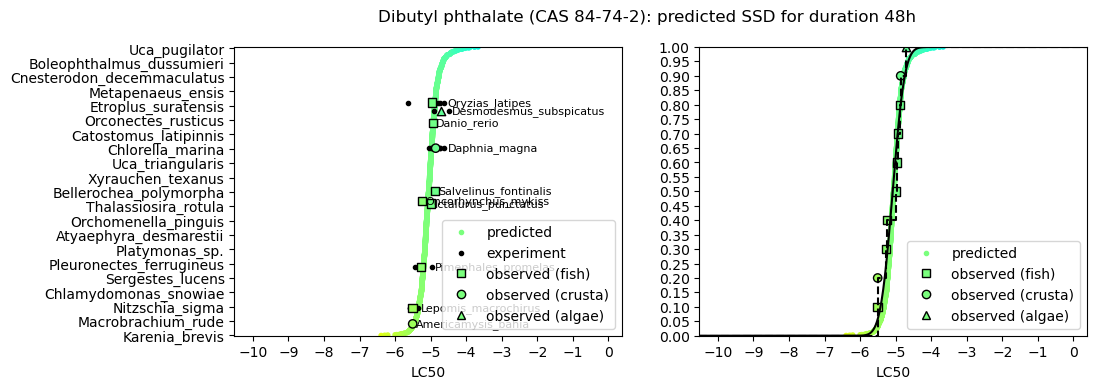

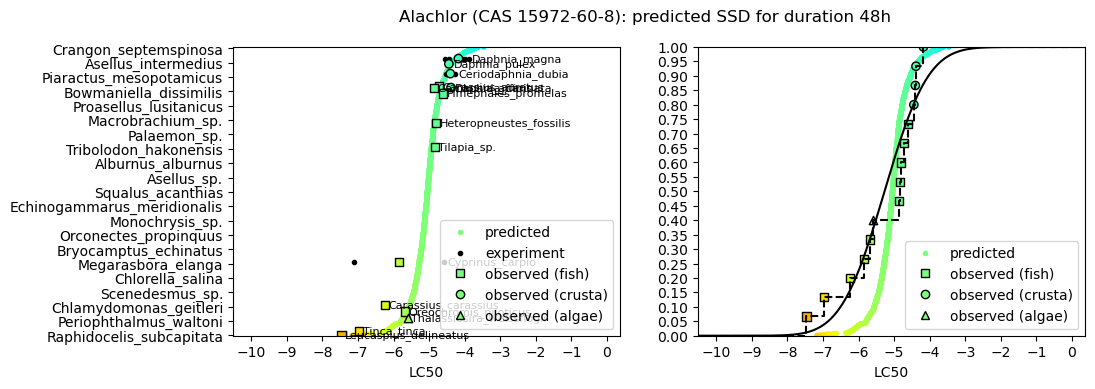

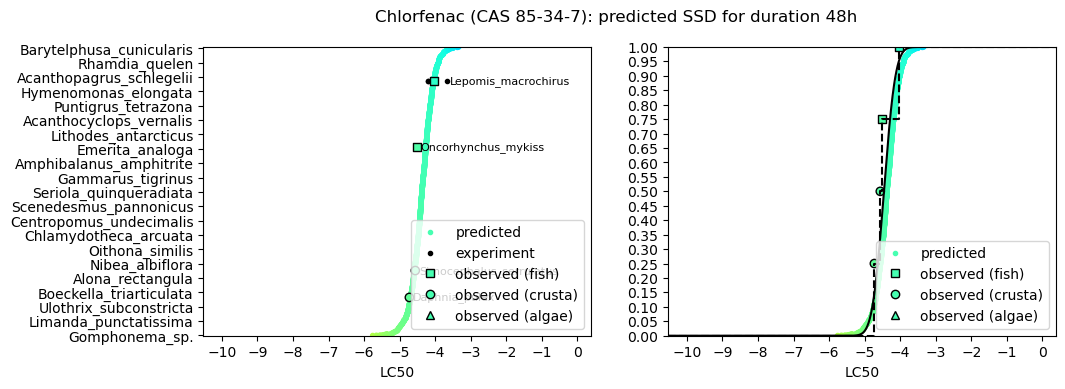

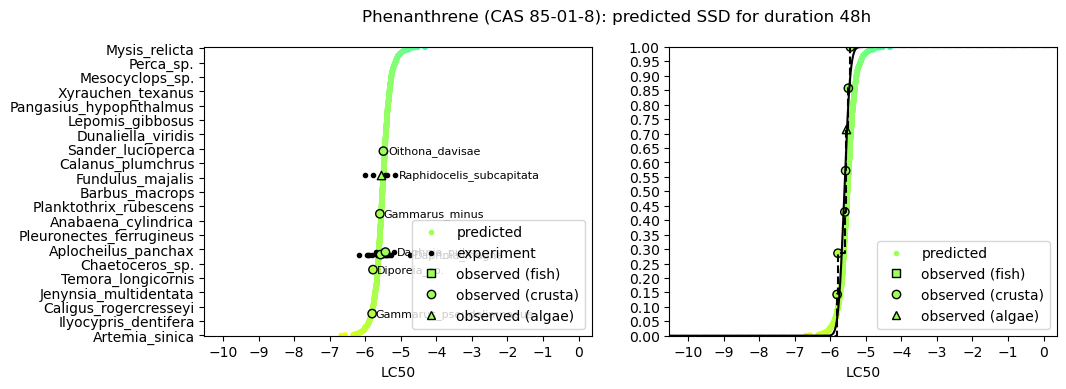

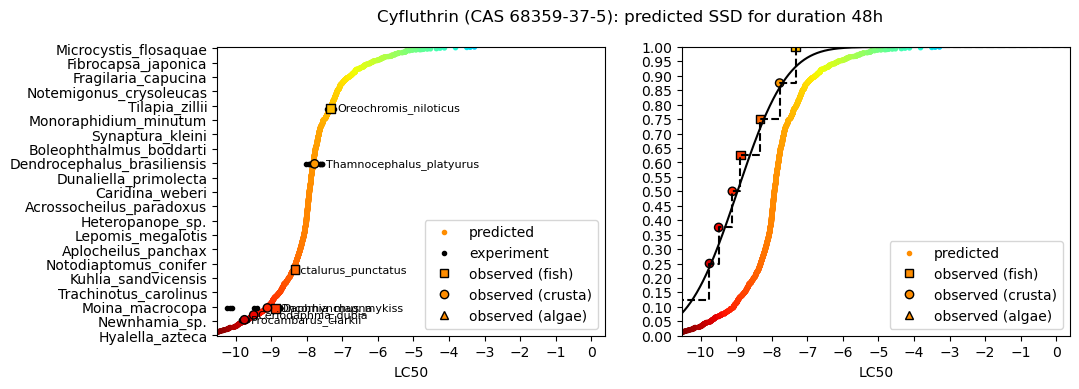

In [225]:
# Plot SSD for validation purposes
duration = 48
for drug in drugs:
    # Predicted and observed LC50 values for species
    ssd_pred = tb[(tb['duration'] == duration) & (tb['CAS'] == drug)].set_index('species')['predicted']
    ssd_obs = df[(df['duration'] == duration) & (df['CAS'] == drug)].set_index('species')['conc']
    # Plot novel and tradional visualization
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(11, 3.75))
    plot_ssd(ssd_pred, ssd_obs, title='', vmin=sdmin, vmax=sdmax, taxonomy=taxonomy, ax=ax1)
    plot_ssd_traditional(ssd_pred, ssd_obs, title='', vmin=sdmin, vmax=sdmax, taxonomy=taxonomy, ax=ax2)
    title = '{0} (CAS {1}): predicted SSD for duration {2}h'.format(names_CAS[drug], drug, duration)
    fig.suptitle(title)
    plt.savefig('ssd_%s.tif'%drug, dpi=300, bbox_inches='tight')
    

### SSD by taxon

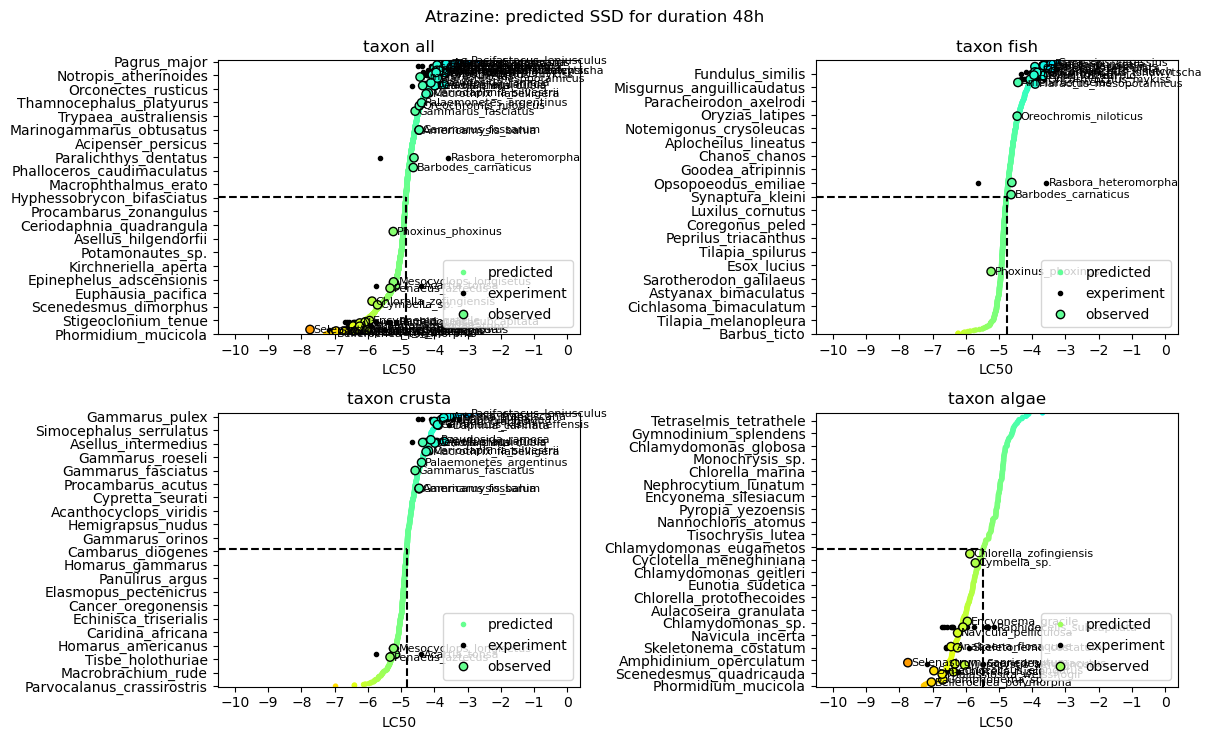

In [226]:
drug = '1912-24-9'

fig, axs = plt.subplots(2,2, figsize=(12, 2*3.75))
ax, axs = axs[0][0], [axs[0][1], axs[1][0], axs[1][1]]
# Predicted and observed LC50 values
ssd_pred = tb[(tb['duration'] == duration) & (tb['CAS'] == drug)].set_index('species')['predicted']
ssd_obs = df[(df['duration'] == duration) & (df['CAS'] == drug)].set_index('species')['conc']
# Plot all species SSD
plot_ssd(ssd_pred, ssd_obs, title='taxon all', vmin=sdmin, vmax=sdmax, median=True, ax=ax)
for tax, ax in zip(['fish', 'crusta', 'algae'], axs):
    # Plot SSD for only species of given taxon
    species_subset = taxonomy[taxonomy == tax].index
    ssd_pred_subset = ssd_pred[ssd_pred.index.isin(species_subset)]
    ssd_obs_subset = ssd_obs[ssd_obs.index.isin(species_subset)]
    plot_ssd(ssd_pred_subset, ssd_obs_subset, title='taxon {0}'.format(tax), vmin=sdmin, vmax=sdmax, median=True, ax=ax)
suptitle = '{0}: predicted SSD for duration {1}h'.format(names_CAS[drug], duration)
fig.suptitle(suptitle)
fig.tight_layout()
plt.savefig('ssd_%s.tif'%drug, dpi=300, bbox_inches='tight')


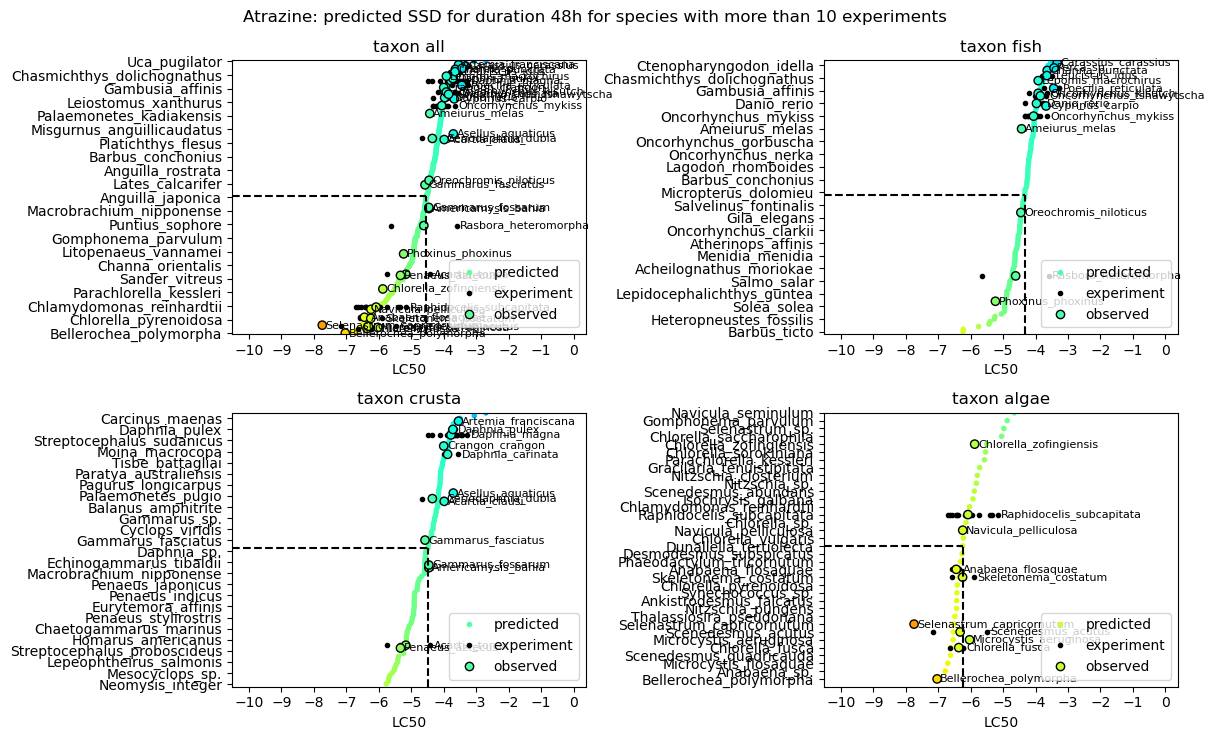

In [227]:
fig, axs = plt.subplots(2,2, figsize=(12, 2*3.75))
ax, axs = axs[0][0], [axs[0][1], axs[1][0], axs[1][1]]
# Predicted and observed LC50 values
ssd_pred = tb[(tb['duration'] == duration) & (tb['CAS'] == drug)].set_index('species')['predicted']
ssd_obs = df[(df['duration'] == duration) & (df['CAS'] == drug)].set_index('species')['conc']
# Plot all species SSD
plot_ssd(ssd_pred[(species_n[ssd_pred.index] >= 10)], ssd_obs[(species_n[ssd_obs.index] >= 10)], title='taxon all', vmin=sdmin, vmax=sdmax, median=True, ax=ax)
for tax, ax in zip(['fish', 'crusta', 'algae'], axs):
    # Plot SSD for only species of given taxon
    species_subset = taxonomy[taxonomy == tax].index
    ssd_pred_subset = ssd_pred[ssd_pred.index.isin(species_subset) & (species_n[ssd_pred.index] >= 10)]
    ssd_obs_subset = ssd_obs[ssd_obs.index.isin(species_subset) & (species_n[ssd_obs.index] >= 10)]
    plot_ssd(ssd_pred_subset, ssd_obs_subset, title='taxon {0}'.format(tax), vmin=sdmin, vmax=sdmax, median=True, ax=ax)
suptitle = '{0}: predicted SSD for duration {1}h for species with more than 10 experiments'.format(names_CAS[drug], duration)
fig.suptitle(suptitle)
fig.tight_layout()
plt.savefig('ssd_geq10_%s.tif'%drug, dpi=300, bbox_inches='tight')


### CHD

In [143]:
# Some example species
species = ['Daphnia_magna', 'Americamysis_bahia', 'Asellus_aquaticus', 'Colisa_fasciata', 'Mugil_curema']
#species = np.random.choice(species_n[species_n >= 5].index, 5, replace=False) 

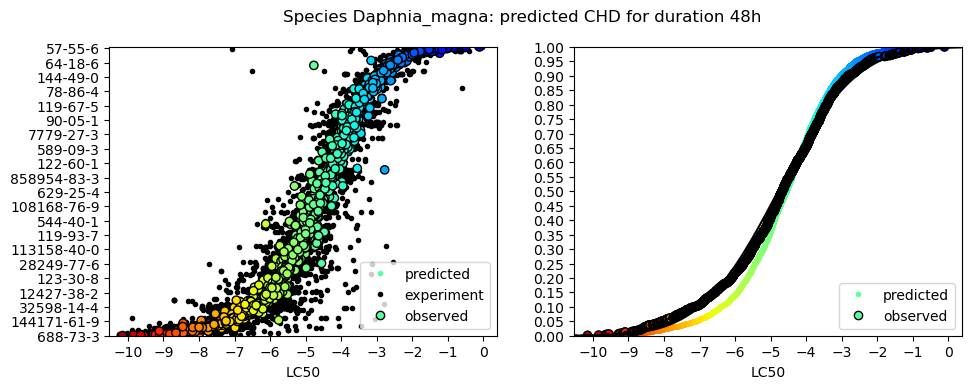

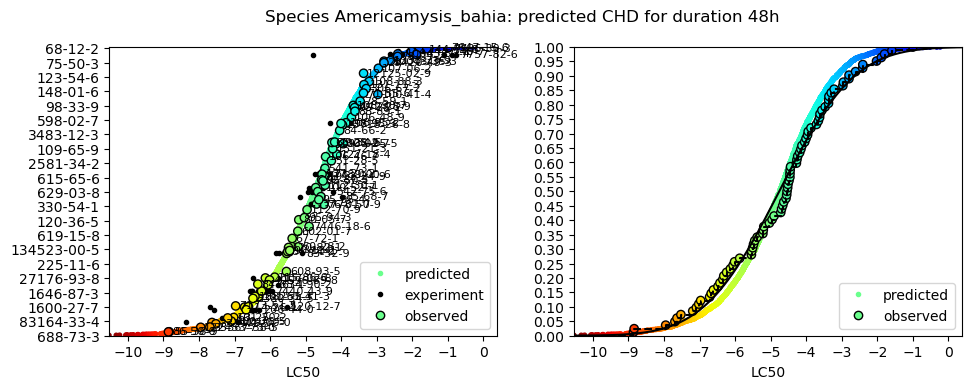

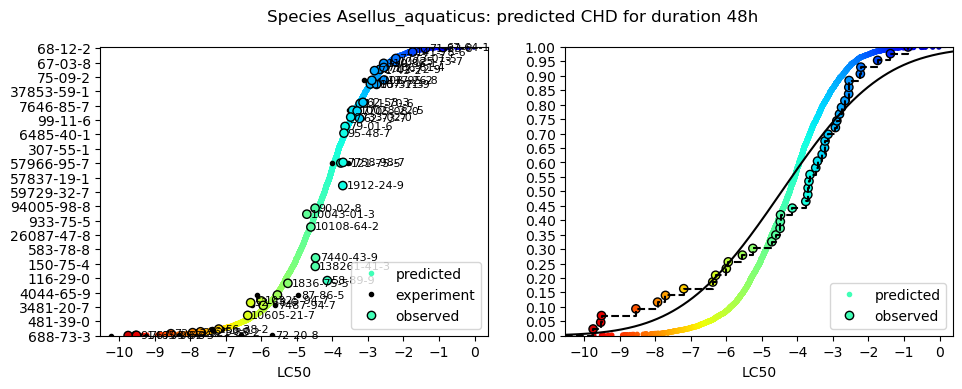

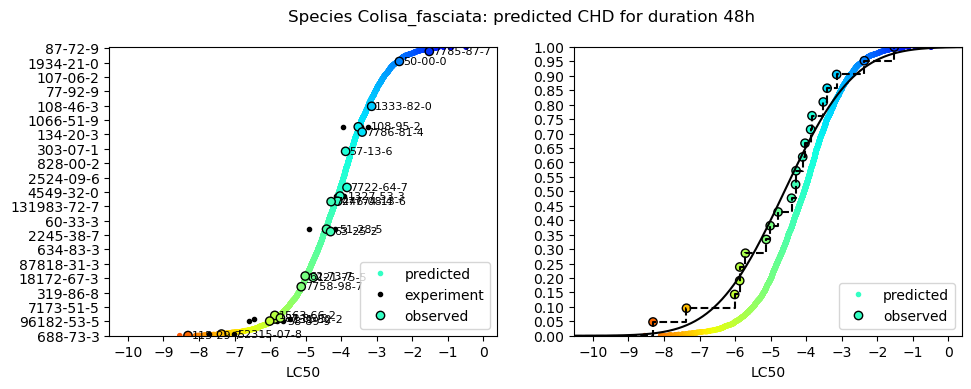

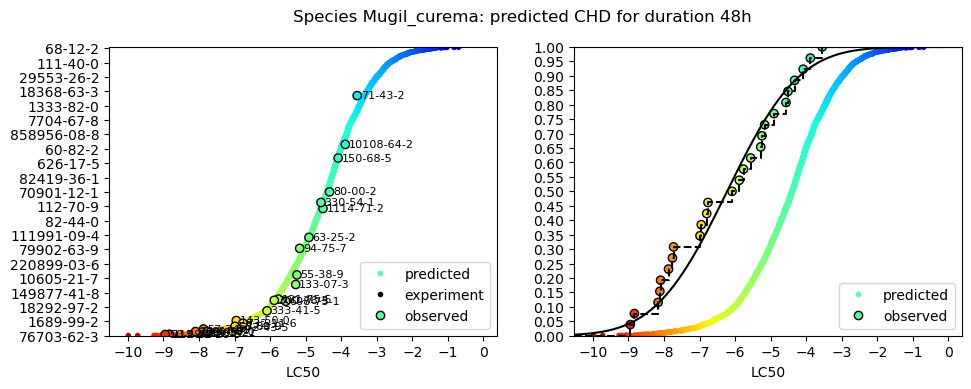

In [144]:
# Plot CHD for validation purposes
duration = 48
for s in species:
    # Predicted vs. observed LC50 values
    ssp_pred = tb[(tb['duration'] == duration) & (tb['species'] == s)].set_index('CAS')['predicted']
    ssp_obs = df[(df['duration'] == duration) & (df['species'] == s)].set_index('CAS')['conc']
    # Plot CHD
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(11, 3.75))
    plot_ssd(ssp_pred, ssp_obs, title='', vmin=sdmin, vmax=sdmax, annotate= s != 'Daphnia_magna',ax=ax1)
    plot_ssd_traditional(ssp_pred, ssp_obs, title='', vmin=sdmin, vmax=sdmax, ax=ax2)
    title = 'Species {0}: predicted CHD for duration {1}h'.format(s, duration)
    fig.suptitle(title)
    plt.savefig('ssp_%s.tif'%s, dpi=300, bbox_inches='tight')


### SSD and CHD parameters

In [158]:
# CHD parameters
params_pred = tb.groupby(['duration', 'species'])['predicted'].agg([np.mean, np.std])
params_obs = df.groupby(['duration', 'species'])['conc'].agg([np.mean, np.std, len])
params = pd.concat({'predicted': params_pred, 'observed': params_obs}, axis=1).sort_index()
params.columns = ['predicted_mean', 'predicted_std', 'observed_mean', 'observed_std', 'n']
params['n'] = params['n'].fillna(0).astype(int)
params.to_csv('params_CHD.csv')

In [159]:
# SSD parameters
params_pred = tb.groupby(['duration', 'CAS'])['predicted'].agg([np.mean, np.std])
params_obs = df.groupby(['duration', 'CAS'])['conc'].agg([np.mean, np.std, len])
params = pd.concat({'predicted': params_pred, 'observed': params_obs}, axis=1).sort_index()
params.columns = ['predicted_mean', 'predicted_std', 'observed_mean', 'observed_std', 'n']
params['n'] = params['n'].fillna(0).astype(int)
params.to_csv('params_SSD.csv')

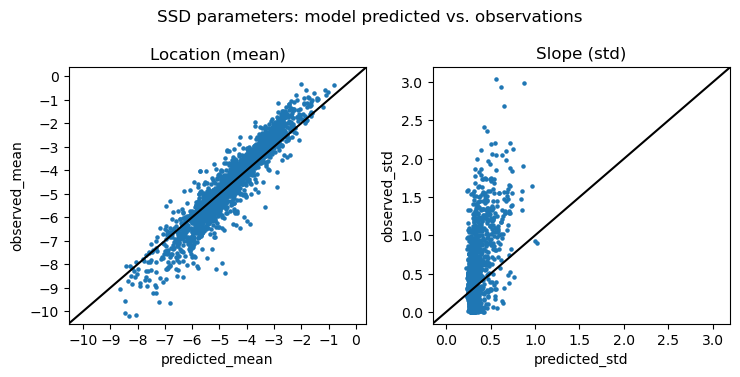

In [160]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(7.5,3.8))

params.loc[48,].plot(ax=ax1, kind='scatter', x=('predicted_mean'), y=('observed_mean'), marker='.')
ax1.axline([0,0], slope=1, color='black')
ax1.set_xlim(sdmin, sdmax)
ax1.set_ylim(sdmin, sdmax)
ax1.set_title('Location (mean)')
ax1.xaxis.set_major_locator(plt.MultipleLocator(1))
ax1.yaxis.set_major_locator(plt.MultipleLocator(1))
params.loc[48,].plot(ax=ax2, kind='scatter', x=('predicted_std'), y=('observed_std'), marker='.')
ax2.axline([0,0], slope=1, color='black')
ax2.set_xlim(ax2.get_ylim())
ax2.set_title('Slope (std)')
ax2.xaxis.set_major_locator(plt.MultipleLocator(0.5))
ax2.yaxis.set_major_locator(plt.MultipleLocator(0.5))
fig.suptitle('SSD parameters: model predicted vs. observations')
fig.tight_layout()